In [1]:
import pandas as pd
import itertools
from datetime import timedelta
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import seaborn as sns
sns.set_context("poster")
plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titleweight'] = 'bold' 

from IPython.display import display, HTML

import numpy as np
import math

import datetime
import time
import sys

import networkx as nx


import sklearn
print("sklearn.__version__:",sklearn.__version__)

import pylab as pl
import matplotlib.dates as mdates

print(sys.version)

sklearn.__version__: 0.19.1
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]


# Data from Kaggle
* https://www.kaggle.com/itamarmushkin/israeli-elections-2015-2013
* https://www.kaggle.com/gefena/political-landscape/data
* https://www.kaggle.com/gefena/political-landscape/notebook

In [2]:
result_df = pd.read_csv('../input/results_by_booth_2015 - english - v3.csv', encoding='iso-8859-1')
print("Columns:")
print(result_df.columns)
print()
print("df shape:",result_df.shape)
result_df.tail(5)

Columns:
Index(['Settlement_name_hebrew', 'Settlement_code', 'settlement_name_english',
       'Booth_number', 'Registered_voters', 'votes', 'bad_votes',
       'proper_votes', 'Ale Yarok', 'Arab List', 'Democratura', 'Green Party',
       'Haim Bekavod', 'Hope for change', 'Joint List', 'Kalkala', 'Kulanu',
       'Likud', 'Meretz', 'Moreshet Avot', 'Na Nach',
       'National Team (temporary)', 'Or', 'Perach', 'Pirate Party', 'Shas',
       'The Jewish Home', 'Ubizchutan', 'United Torah Judaism', 'Yachad',
       'Yesh Atid', 'Yisrael Beiteinu', 'Zionist Union'],
      dtype='object')

df shape: (10414, 33)


,Settlement_name_hebrew,Settlement_code,settlement_name_english,Booth_number,Registered_voters,votes,bad_votes,proper_votes,Ale Yarok,Arab List,...,Perach,Pirate Party,Shas,The Jewish Home,Ubizchutan,United Torah Judaism,Yachad,Yesh Atid,Yisrael Beiteinu,Zionist Union
10409,ú÷åò,3563,TEQOA,2.0,476,369,1,368,3,0,...,0,0,2,144,2,7,32,4,13,9
10410,ú÷åò,3563,TEQOA,3.0,645,533,0,533,9,0,...,0,0,5,265,2,3,48,4,14,6
10411,úøàáéï à-öàðò (ùá,970,TARABIN AS-SANI,1.0,639,106,0,106,0,5,...,0,0,2,0,0,0,0,0,0,2
10412,úøàáéï à-öàðò(éùå,1346,TARABIN AS-SANI,1.0,176,60,0,60,0,3,...,0,0,3,1,0,1,0,0,0,1
10413,úøåí,778,TARUM,1.0,482,411,2,409,5,0,...,0,0,37,111,0,4,24,13,1,23


# Clean Data

In [3]:
result_df = result_df.dropna(axis=0, how='any')
result_df = result_df[result_df.votes > 0]
result_df.loc[result_df.Registered_voters == 0,'Registered_voters'] = result_df[result_df.Registered_voters == 0].votes
result_df.shape

(10412, 33)

# Overall Votes Per Party

In [4]:
block_percent = 0.0325

all registerd voters: 6114936
all_votes: 4210884
vote percentage: 0.6886227427400712


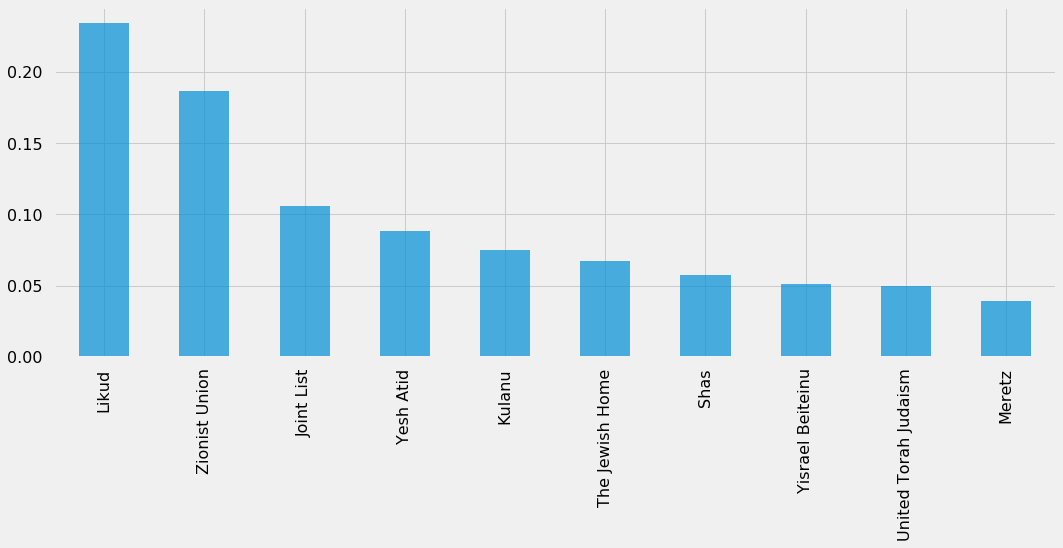

In [5]:
all_registered_voters = result_df.Registered_voters.sum()
all_votes = result_df.proper_votes.sum()
print("all registerd voters:",all_registered_voters)
print("all_votes:",all_votes)
print("vote percentage:",all_votes/all_registered_voters)
overall_votes_per_party = result_df.iloc[:,8:].sum()
percantage_vote_per_pary = overall_votes_per_party/all_votes
percantage_vote_per_pary = percantage_vote_per_pary[percantage_vote_per_pary.values>block_percent]
percantage_vote_per_pary.sort_values(ascending=False).plot.bar(alpha=0.7,figsize=(16,6))

# Group by City and Filter Out Small Parties

In [6]:
# Print the large parties
large_parties = percantage_vote_per_pary.index.values
print(large_parties)

['Joint List' 'Kulanu' 'Likud' 'Meretz' 'Shas' 'The Jewish Home'
 'United Torah Judaism' 'Yesh Atid' 'Yisrael Beiteinu' 'Zionist Union']


In [7]:
non_party_col = list(result_df.iloc[:,0:8].columns)
int_columns = []
int_columns.extend(non_party_col)
int_columns.extend(list(large_parties))
print(int_columns)

['Settlement_name_hebrew', 'Settlement_code', 'settlement_name_english', 'Booth_number', 'Registered_voters', 'votes', 'bad_votes', 'proper_votes', 'Joint List', 'Kulanu', 'Likud', 'Meretz', 'Shas', 'The Jewish Home', 'United Torah Judaism', 'Yesh Atid', 'Yisrael Beiteinu', 'Zionist Union']


In [8]:
res_work_df = result_df.copy()
res_work_df = res_work_df[int_columns]
res_work_df_city = res_work_df.groupby(['settlement_name_english','Settlement_code'])[int_columns[4:]].sum().reset_index()
print(res_work_df_city.shape)
res_work_df_city.head(5)

(1196, 16)


,settlement_name_english,Settlement_code,Registered_voters,votes,bad_votes,proper_votes,Joint List,Kulanu,Likud,Meretz,Shas,The Jewish Home,United Torah Judaism,Yesh Atid,Yisrael Beiteinu,Zionist Union
0,A'SAM,963,4129,1331,25,1306,1055,9,10,9,85,1,4,1,3,80
1,ABBIRIM,1220,160,123,1,122,3,6,9,34,4,0,0,12,1,48
2,ABU ABDUN,958,119,37,1,36,35,0,0,0,0,0,0,0,0,0
3,ABU GHOSH,472,4178,2539,33,2506,2114,21,58,41,35,10,4,14,5,143
4,ABU JUWEI'ID,967,1610,313,7,306,242,1,3,8,2,0,0,1,0,39


# Remove low votings rates

In [9]:
min_vote_rate = 0.6
min_proper_votes = 300

In [10]:
res_work_df = res_work_df_city.copy()
res_work_df['vote_rate'] = res_work_df.proper_votes / res_work_df.Registered_voters
res_work_df = res_work_df[(res_work_df.vote_rate > min_vote_rate) & (res_work_df.proper_votes > min_proper_votes)]
print(res_work_df.shape)
res_work_df.sample(10)

(724, 17)


,settlement_name_english,Settlement_code,Registered_voters,votes,bad_votes,proper_votes,Joint List,Kulanu,Likud,Meretz,Shas,The Jewish Home,United Torah Judaism,Yesh Atid,Yisrael Beiteinu,Zionist Union,vote_rate
1169,ZEKHARYA,799,686,554,0,554,0,52,352,2,38,26,2,14,4,42,0.807580
545,KEFAR TAVOR,47,2785,2097,3,2094,6,163,413,96,16,144,5,324,28,852,0.751885
1171,ZEMER,1290,4088,2583,15,2568,2310,6,24,127,3,2,1,2,1,58,0.628180
680,MESHHED,520,4907,3370,12,3358,3128,53,24,91,7,0,0,0,1,41,0.684329
229,EFRAT,3650,5868,4583,14,4569,1,107,1394,24,32,2501,26,71,30,81,0.778630
9,ABU SINAN,473,8363,5798,52,5746,3802,158,255,66,213,10,3,41,799,299,0.687074
80,ATSMON SEGEV,917,825,617,1,616,0,24,29,117,3,17,0,72,2,349,0.746667
1070,TEL ADASHIM,103,750,613,1,612,1,41,111,24,2,32,2,116,7,263,0.816000
114,BAT SHELOMO,33,397,323,3,320,2,26,49,38,2,17,1,46,6,117,0.806045
122,BE'ERI,399,804,669,2,667,0,13,18,109,0,14,1,50,5,443,0.829602


In [11]:
res_work_df[res_work_df.settlement_name_english.str.contains("BE'ER SHEVA|TEL AVIV|JERU|HAI")] # BE'ER SHEVA / TEL AVIV / JERUSALEM 

,settlement_name_english,Settlement_code,Registered_voters,votes,bad_votes,proper_votes,Joint List,Kulanu,Likud,Meretz,Shas,The Jewish Home,United Torah Judaism,Yesh Atid,Yisrael Beiteinu,Zionist Union,vote_rate
119,BE'ER SHEVA,9000,156696,98505,1352,97153,531,8548,36614,1357,6178,6782,676,7364,11721,11887,0.620009
387,HAIFA,4000,243274,151318,1758,149560,12363,12697,31025,6783,3342,8032,4894,16826,12010,37805,0.614780
462,JERUSALEM,3000,385888,258879,3593,255286,3148,11949,61874,10166,30579,21266,53948,10752,6032,24696,0.661555
1071,TEL AVIV - YAFO,5000,403338,263205,1860,261345,8488,17989,47526,34056,10189,8772,2628,30241,5446,89567,0.647955


# Check if there are bad rows with infinite values

In [12]:
res_work_df[res_work_df.vote_rate == np.inf]

,settlement_name_english,Settlement_code,Registered_voters,votes,bad_votes,proper_votes,Joint List,Kulanu,Likud,Meretz,Shas,The Jewish Home,United Torah Judaism,Yesh Atid,Yisrael Beiteinu,Zionist Union,vote_rate


# Calculate percentage votes for each city-party

In [13]:
res_work_df_percentage_votes = res_work_df.iloc[:,6:-1].div(res_work_df.proper_votes, axis=0)
res_work_df_percentage_votes.head(5)

,Joint List,Kulanu,Likud,Meretz,Shas,The Jewish Home,United Torah Judaism,Yesh Atid,Yisrael Beiteinu,Zionist Union
9,0.661678,0.027497,0.044379,0.011486,0.037069,0.001740,0.000522,0.007135,0.139053,0.052036
12,0.002625,0.055118,0.506562,0.023622,0.068241,0.204724,0.002625,0.039370,0.026247,0.031496
14,0.000000,0.086876,0.165434,0.035120,0.002773,0.047135,0.000924,0.231054,0.012939,0.400185
16,0.003279,0.029508,0.042623,0.075410,0.006557,0.026230,0.000000,0.111475,0.006557,0.681967
18,0.001385,0.023546,0.024931,0.098338,0.001385,0.029086,0.002770,0.078947,0.011080,0.703601


# Clustering

In [14]:
res_work_df_percentage_votes_transpose = res_work_df_percentage_votes.transpose()
res_work_df_percentage_votes_transpose.head(11)

,9,12,14,16,18,19,22,23,24,25,...,1178,1179,1181,1184,1185,1186,1189,1190,1192,1194
Joint List,0.661678,0.002625,0.000000,0.003279,0.001385,0.000742,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.005181,0.003333,0.027829,0.002309,0.000000,0.004050,0.001497,0.000543,0.000000
Kulanu,0.027497,0.055118,0.086876,0.029508,0.023546,0.086564,0.053066,0.051570,0.155689,0.154128,...,0.052747,0.031088,0.045000,0.018553,0.046189,0.060672,0.078637,0.077844,0.085870,0.045356
Likud,0.044379,0.506562,0.165434,0.042623,0.024931,0.442160,0.305425,0.576233,0.477545,0.269725,...,0.125275,0.113990,0.090000,0.035250,0.043880,0.294691,0.265272,0.102545,0.151630,0.079914
Meretz,0.011486,0.023622,0.035120,0.075410,0.098338,0.009167,0.002358,0.004484,0.001497,0.022018,...,0.092308,0.290155,0.123333,0.168831,0.064665,0.008667,0.092474,0.063623,0.050000,0.060475
Shas,0.037069,0.068241,0.002773,0.006557,0.001385,0.059586,0.370283,0.069507,0.235030,0.022018,...,0.000000,0.000000,0.001667,0.000000,0.000000,0.009751,0.014850,0.005240,0.008696,0.006479
The Jewish Home,0.001740,0.204724,0.047135,0.026230,0.029086,0.057534,0.159198,0.147982,0.023952,0.064220,...,0.052747,0.023316,0.028333,0.016698,0.020785,0.419285,0.071212,0.035180,0.061413,0.049676
United Torah Judaism,0.000522,0.002625,0.000924,0.000000,0.002770,0.018596,0.029481,0.020179,0.020958,0.003670,...,0.004396,0.000000,0.001667,0.001855,0.002309,0.005417,0.004050,0.005240,0.002717,0.004320
Yesh Atid,0.007135,0.039370,0.231054,0.111475,0.078947,0.070063,0.005896,0.024664,0.019461,0.163303,...,0.184615,0.088083,0.151667,0.074212,0.087760,0.061755,0.141073,0.197605,0.230978,0.196544
Yisrael Beiteinu,0.139053,0.026247,0.012939,0.006557,0.011080,0.109525,0.002358,0.006726,0.001497,0.007339,...,0.019780,0.007772,0.008333,0.000000,0.002309,0.013001,0.034425,0.001497,0.016848,0.017279
Zionist Union,0.052036,0.031496,0.400185,0.681967,0.703601,0.110485,0.003538,0.015695,0.038922,0.269725,...,0.441758,0.427461,0.530000,0.641929,0.709007,0.061755,0.273372,0.496257,0.369022,0.520518


## Run K-Means
- Tanspose matrix
- Convert numeric voting rate to (1,0) where 1 means the voting rate in that settelment was above the median

In [15]:
X = res_work_df_percentage_votes_transpose
X.head(3)

,9,12,14,16,18,19,22,23,24,25,...,1178,1179,1181,1184,1185,1186,1189,1190,1192,1194
Joint List,0.661678,0.002625,0.000000,0.003279,0.001385,0.000742,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.005181,0.003333,0.027829,0.002309,0.000000,0.004050,0.001497,0.000543,0.000000
Kulanu,0.027497,0.055118,0.086876,0.029508,0.023546,0.086564,0.053066,0.051570,0.155689,0.154128,...,0.052747,0.031088,0.045000,0.018553,0.046189,0.060672,0.078637,0.077844,0.085870,0.045356
Likud,0.044379,0.506562,0.165434,0.042623,0.024931,0.442160,0.305425,0.576233,0.477545,0.269725,...,0.125275,0.113990,0.090000,0.035250,0.043880,0.294691,0.265272,0.102545,0.151630,0.079914


In [16]:
def above_median(fclist):
    med = np.median(fclist)
    return (fclist > med).astype(int)

X = X.apply(above_median, axis=1)

In [17]:
X[1:10]

,9,12,14,16,18,19,22,23,24,25,...,1178,1179,1181,1184,1185,1186,1189,1190,1192,1194
Kulanu,0,0,1,0,0,1,0,0,1,1,...,0,0,0,0,0,1,1,1,1,0
Likud,0,1,1,0,0,1,1,1,1,1,...,0,0,0,0,0,1,1,0,1,0
Meretz,0,0,0,1,1,0,0,0,0,0,...,1,1,1,1,1,0,1,1,1,1
Shas,1,1,0,1,0,1,1,1,1,1,...,0,0,0,0,0,1,1,0,1,1
The Jewish Home,0,1,1,0,0,1,1,1,0,1,...,1,0,0,0,0,1,1,0,1,1
United Torah Judaism,0,1,0,0,1,1,1,1,1,1,...,1,0,0,0,0,1,1,1,1,1
Yesh Atid,0,0,1,1,0,0,0,0,0,1,...,1,0,1,0,0,0,1,1,1,1
Yisrael Beiteinu,1,1,1,0,1,1,0,0,0,0,...,1,0,0,0,0,1,1,0,1,1
Zionist Union,0,0,1,1,1,0,0,0,0,0,...,1,1,1,1,1,0,0,1,1,1


In [18]:
names = res_work_df_percentage_votes_transpose.index.tolist()

In [19]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4, random_state=0).fit(X)
clusters = km.labels_.tolist()
clusters

[3, 2, 0, 1, 0, 0, 0, 1, 2, 1]

## Visualize Clusters

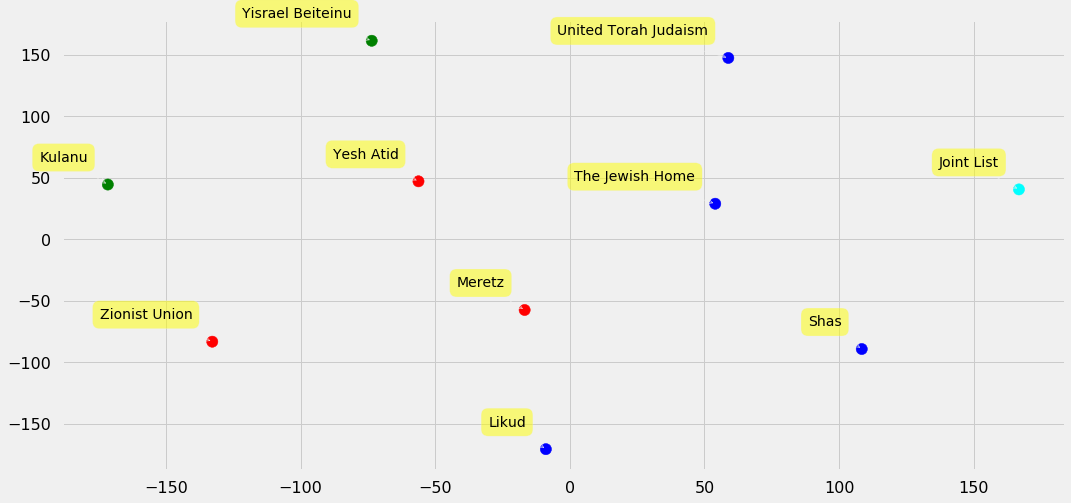

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
results_tsne = tsne.fit(X)

coords = results_tsne.embedding_

colors = ['blue','red','green','cyan','magenta','yellow','black','white']
label_colors = [colors[i] for i in clusters]

plt.figure(figsize=(16,8)) 
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o', c=label_colors
    )

for label, x, y in zip(names, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    
plt.show()

# Distance Matrix

In [21]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler

x = res_work_df_percentage_votes_transpose

res = pairwise_distances(x, metric='correlation') # cosine / jaccard / correlation / euclidean

distance = pd.DataFrame(res, index=res_work_df_percentage_votes_transpose.index, 
                        columns= res_work_df_percentage_votes_transpose.index)

distance

,Joint List,Kulanu,Likud,Meretz,Shas,The Jewish Home,United Torah Judaism,Yesh Atid,Yisrael Beiteinu,Zionist Union
Joint List,0.000000,1.367228,1.349719,1.135943,1.093125,1.190827,1.060608,1.422978,1.086445,1.353393
Kulanu,1.367228,0.000000,0.387466,1.250750,0.821314,1.212273,1.114415,0.670297,0.821421,1.037505
Likud,1.349719,0.387466,0.000000,1.496075,0.600312,0.810013,1.035258,1.096753,0.774399,1.499037
Meretz,1.135943,1.250750,1.496075,0.000000,1.313049,1.351136,1.137316,0.802393,1.169799,0.416618
Shas,1.093125,0.821314,0.600312,1.313049,0.000000,1.032138,0.600705,1.317005,0.860421,1.414061
The Jewish Home,1.190827,1.212273,0.810013,1.351136,1.032138,0.000000,1.032231,1.368666,1.059215,1.496226
United Torah Judaism,1.060608,1.114415,1.035258,1.137316,0.600705,1.032231,0.000000,1.189887,1.009505,1.202599
Yesh Atid,1.422978,0.670297,1.096753,0.802393,1.317005,1.368666,1.189887,0.000000,1.018558,0.373886
Yisrael Beiteinu,1.086445,0.821421,0.774399,1.169799,0.860421,1.059215,1.009505,1.018558,0.000000,1.152551
Zionist Union,1.353393,1.037505,1.499037,0.416618,1.414061,1.496226,1.202599,0.373886,1.152551,0.000000


## Hierarchical Clustering

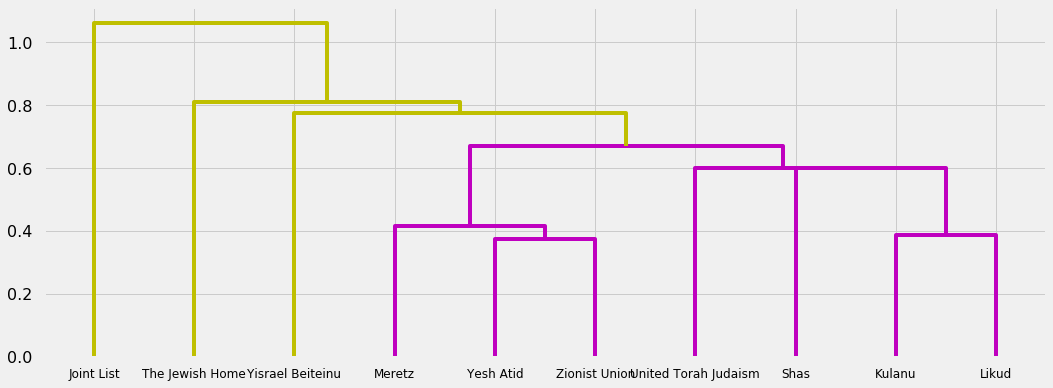

In [22]:
import scipy
from scipy.cluster import hierarchy

labels = distance.index.values.tolist()
sq_distance = scipy.spatial.distance.squareform(distance)

Z = hierarchy.linkage(sq_distance, 'single')

hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
dn1 = hierarchy.dendrogram(Z, ax=axes, above_threshold_color='y', orientation='top', labels=labels)
plt.show()

## Heatmap of Distance Matrix Reordered as the Dendrogram

In [23]:
new_order_distance = distance.reindex(dn1['ivl'])
new_order_distance = new_order_distance[dn1['ivl']] 

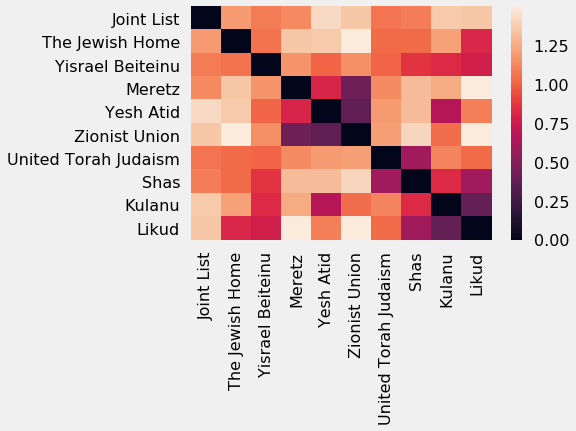

In [24]:
import seaborn as sns
ax = sns.heatmap(new_order_distance)

# Build Network

In [25]:
distance_cutoff = 1
parties = percantage_vote_per_pary.index.tolist()
parties

['Joint List',
 'Kulanu',
 'Likud',
 'Meretz',
 'Shas',
 'The Jewish Home',
 'United Torah Judaism',
 'Yesh Atid',
 'Yisrael Beiteinu',
 'Zionist Union']

In [26]:
import itertools
dist_list = list(distance.index)
all_2_org_combos = itertools.combinations(dist_list, 2)
max_dist = distance.max().max()

# Generate graph with nodes: 
G=nx.Graph()

for p in parties:
    G.add_node(p,
               name=p,
               p_vote=float(percantage_vote_per_pary[p]),             
               comm="0") 
    
# Connect nodes:
for combo in all_2_org_combos:
    combo_dist = distance[combo[0]][combo[1]]
    opp_dist = combo_dist - max_dist
    if distance[combo[0]][combo[1]] < distance_cutoff:
        G.add_edge(combo[0],combo[1],weight=float(abs(opp_dist)))
        

n = G.number_of_nodes()
m = G.number_of_edges()     
print("number of nodes in graph G: ",n)
print("number of edges in graph G: ",m)
print()

number of nodes in graph G:  10
number of edges in graph G:  12



## Communities and Modularity

In [27]:
import community
communities = community.best_partition(G)
mod = community.modularity(communities,G)
print("modularity:", mod)

modularity: 0.3598905181179209


In [28]:
if m > 0:         
    for k,v in communities.items():
        G.node[k]['comm'] = str(v)
else:
    print("Not runnig Community algorithm because the graph has no edges")

## Draw Network

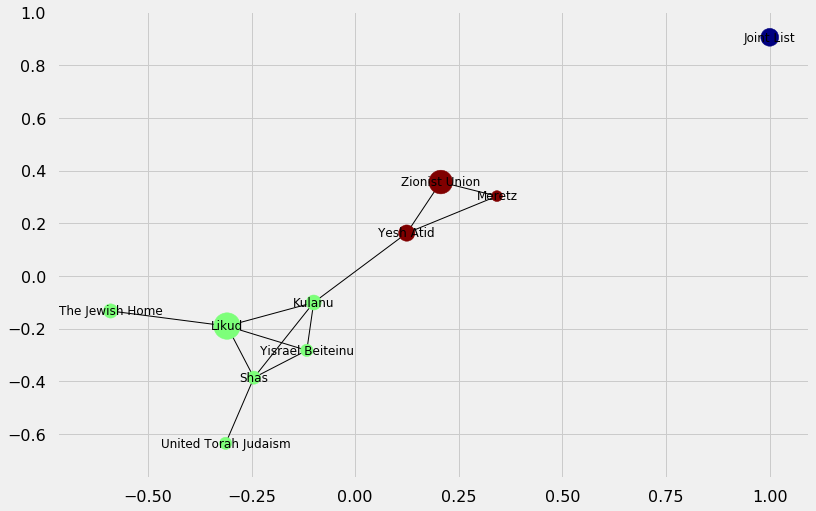

In [29]:
com_values = [communities.get(node) for node in G.nodes()]

p_votes = [d['p_vote'] for n,d in G.nodes(data=True)]
node_size=[v * 3000 for v in p_votes]

plt.figure(figsize=(12,8)) 
pos=nx.fruchterman_reingold_layout(G)
nx.draw_networkx(G,pos, cmap = plt.get_cmap('jet'), node_color = com_values, node_size=node_size, with_labels=True)
plt.show()